In [2]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [5]:
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL
from typing import List, Dict, Annotated
from langchain.tools import tool

from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor
from langchain_teddynote.messages import AgentStreamParser

In [6]:
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

In [7]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result

In [8]:
tools = [search_news, python_repl_tool]

In [9]:
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공합니다. (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        (                                           
            "system",
            "You are a helpful assistant. "             
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),          # 이전 대화 내용을 넣을 곳을 잡아둔다.
        ("human", "{input}"),                       # 사용자 입력

        # 에이전트가 검색하는 과정들이나 내용 등을 끄적이는 메모장 같은 공간을 플레이스 홀더로 만들어준다
        ("placeholder", "{agent_scratchpad}"),       
    ]
)

In [10]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [11]:
agent = create_tool_calling_agent(llm, tools, prompt)

In [12]:
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
)

In [13]:
# 스트리밍 모드로 실행.
result = agent_executor.stream({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})

# 중간 단계 출력
for step in result:    
    print(step)
    print("===" * 20)



> Entering new None chain...
{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI 투자'}, log="\nInvoking: `search_news` with `{'query': 'AI 투자'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_xQSzwGvatrbvIP9x3zFfrcnh', 'function': {'arguments': '{"query":"AI 투자"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb'}, id='run-431fa48e-9237-45bd-85c3-c7c186dbfbba', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI 투자'}, 'id': 'call_xQSzwGvatrbvIP9x3zFfrcnh', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"AI 투자"}', 'id': 'call_xQSzwGvatrbvIP9x3zFfrcnh', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_xQSzwGvatrbvIP9x3zFfrcnh')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_x

In [14]:
agent_stream_parser = AgentStreamParser()



> Entering new None chain...


Python REPL can execute arbitrary code. Use with caution.


[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# 파이 차트 그리기
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart Example')

# 차트 보여주기
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']\n\n# 파이 차트 그리기\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Pie Chart Example')\n\n# 차트 보여주기\nplt.show()"}`




Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 

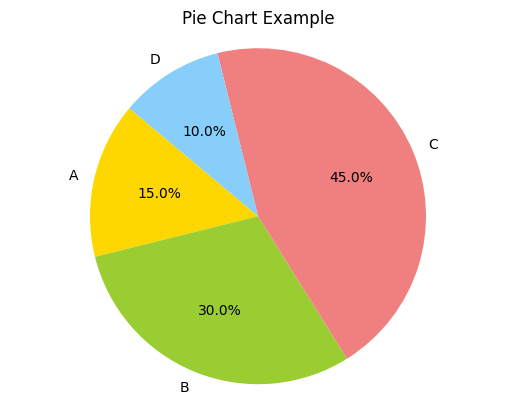

[관찰 내용]
Observation: 
차트가 성공적으로 그려졌습니다. 위 코드는 Matplotlib을 사용하여 파이 차트를 생성하는 예제입니다. 데이터는 4개의 카테고리(A, B, C, D)로 나누어져 있으며, 각 카테고리의 비율을 시각적으로 표현합니다. 

차트는 다음과 같은 요소를 포함합니다:
- 각 카테고리의 비율을 퍼센트로 표시
- 색상으로 각 카테고리를 구분
- 원형 비율을 유지하여 차트를 원으로 표시

추가적인 질문이 있으시면 말씀해 주세요!

> Finished chain.
[최종 답변]
차트가 성공적으로 그려졌습니다. 위 코드는 Matplotlib을 사용하여 파이 차트를 생성하는 예제입니다. 데이터는 4개의 카테고리(A, B, C, D)로 나누어져 있으며, 각 카테고리의 비율을 시각적으로 표현합니다. 

차트는 다음과 같은 요소를 포함합니다:
- 각 카테고리의 비율을 퍼센트로 표시
- 색상으로 각 카테고리를 구분
- 원형 비율을 유지하여 차트를 원으로 표시

추가적인 질문이 있으시면 말씀해 주세요!


In [15]:
 # 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 agent_stream_parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)

In [16]:
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser

# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름을 출력합니다.
    print("<<<<<<< 도구 호출 >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print(
        f"Observation: {observation.get('observation')[0]}"
    )  # 관찰 내용을 출력합니다.
    print("<<<<<<< 관찰 내용 >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(result)  # 최종 답변을 출력합니다.
    print("<<<<<<< 최종 답변 >>>>>>")


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

In [17]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream({"input": "AI 투자관련 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>

Invoking: `search_news` with `{'query': 'AI 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMiVkFVX3lxTE9HMzNkMXZaZ0k2ekVETmtLNVI2bVVrQlBkbVE3Ry1IenhrWkR1d2pCeHk1ZnNIVjVSVWx4VDRTdjZxcWtsdlhLYTJ4aFVzQzkyNHhsa2pB?oc=5', 'content': '"투자·인재·제도 열악한데 AI 3강?"…韓, 마이너리그 전락 \'우려\' - ZD넷 코리아'}, {'url': 'https://news.google.com/rss/articles/CBMickFVX3lxTFA4T3ZXMmM5VUVTSUxsYzhPaktQMWtzcE5VUHlUaUNMV0FpSmVacTRFWjd0TlhYTXVpdWdZNExFcUxWZTZMRmk5RDh0TXVkeVhfcjdXT3JnZzRNWXNkZFRrTkNTbDc3Skx3SHBacW9KeENvQQ?oc=5', 'content': '오픈AI가 픽한 유니콘…‘스픽’ 1100억 투자 유치 - 마켓인'}, {'url': 'https://news.google.com/rss/articles/CBMiZkFVX3lxTE93b21ZV0twWUxEMW1IRk1OQlFmY251Nk0xYlBwblZyTE0wSlRtbzl4N3NHTmJDR1puQ2hoWi1IT2otVEFvNkRzY0t4S0lCSGJGV2l4UFYtNHRDeS0wTGVnbFRnRko5Zw?oc=5', 'content': "SKT, AI 영상분석 '트웰브랩스'에 300만달러 투자 - 머니투데이"}, {'url': 'https://news.google.com/rss/articles/CBMi2gJBVV95cUxQYzQxQXJTdFNIVkVjYXlNTDVtRHJqUm1hOEl4NW